# Optimizing Marketing Campaigns with Machine Learning

NOTE, this is just an example and not based on a real client.

#### Background:
A large e-commerce company approached our data science consultancy to help improve the performance of their marketing campaigns. The company had been using traditional marketing methods such as email and social media, but they wanted to explore the potential of machine learning to optimize their campaigns and improve their return on investment (ROI).

#### Objective:
Our objective was to develop a machine learning model that could predict the likelihood of a customer making a purchase based on their past behavior and interactions with the company. We then used this model to optimize the company's marketing campaigns by targeting customers who were most likely to make a purchase.

#### Data:
We obtained the company's customer data, which included information such as demographics, purchase history, website interactions, and email responses. The data was in a structured format and was stored in a CSV file. Data can be found [here](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#)

#### Steps:

1. Data Cleaning and Preprocessing: We cleaned and preprocessed the data to remove any missing or invalid values, and to transform the data into a format suitable for machine learning.

2. Feature Engineering: We extracted meaningful features from the data, such as the frequency and recency of customer interactions, and created new features that could capture the customer's behavior and preferences.

3. Model Development: We developed a machine learning model using logistic regression that could predict the probability of a customer making a purchase. We trained the model using a portion of the data and evaluated its performance using metrics such as accuracy and AUC-ROC.

4. Model Deployment: We deployed the model as a web service that could be called by the company's marketing team to obtain predictions for each customer. The predictions were then used to target customers who were most likely to make a purchase.

#### Results:
The machine learning model was able to predict the likelihood of a customer making a purchase with an accuracy of 85%. By targeting customers who were most likely to make a purchase, the company was able to increase their conversion rate by 25% and their ROI by 15%. The company also saw a decrease in their marketing costs as they were able to focus their resources on the most profitable customers.

#### Conclusion:
This case study demonstrates the power of machine learning in optimizing marketing campaigns and improving business performance. By leveraging data science techniques, companies can gain valuable insights into their customers' behavior and preferences, and use this knowledge to make data-driven decisions that drive business success.

# The Code

## Step 1: Data Cleaning and Preprocessing

In [138]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import joblib

import requests
import json

In [2]:
data = pd.read_csv('Data/online_shoppers_intention.csv')

In [3]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


The client defined the columns in the data as:

The 'Revenue' attribute can be used as the class label.

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories.The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another.

The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.

The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

In [4]:
print(data.isnull().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


No null values in the dataset

#### Convert categorical values to numeric

In [5]:
data['Month'] = data['Month'].map({'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
                                   'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12})

In [6]:
data.VisitorType.value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

Set "Other" to the same value as "New_Visitor". We can then treat this field as a boolean.

In [7]:
data['VisitorType'] = data['VisitorType'].map({'Returning_Visitor': 1, 'New_Visitor': 0, 'Other': 0})

In [8]:
data['Weekend'] = data['Weekend'].map({True: 1, False: 0})

In [9]:
data['Revenue'] = data['Revenue'].astype(int)

In [10]:
data.Revenue.value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

The label "Revenue" is pretty imbablenced. We'll have to use some kind of balencing technique when building the model.

## Step 2: Feature Engineering

Just some basic feature engineering.

In [11]:
data['TotalTimeOnSite'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']

In [12]:
data['TotalPageviews'] = data['Administrative'] + data['Informational'] + data['ProductRelated']

## Step 3: Model Development

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Revenue', axis=1), data['Revenue'], test_size=0.3, random_state=42)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size=0.05, random_state=42)

In [14]:
model = DecisionTreeClassifier()
scaler = StandardScaler()
over = SMOTE(n_jobs=-1)
under = RandomUnderSampler()
steps = [('scale', scaler), ('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [15]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [16]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [17]:
scores

array([0.56427379, 0.55319149, 0.58287796, 0.56347826, 0.56206897,
       0.54421769, 0.57142857, 0.60983607, 0.58018018, 0.60067114,
       0.61888112, 0.59027778, 0.54966887, 0.57885615, 0.55405405])

In [18]:
print(scores.mean())
print(scores.std())

0.5749308058613434
0.02170490877265545


Not great using default pipeline. Performing a grid search to see if we can improve the model.

In [19]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(model__criterion=criterion, model__max_depth=max_depth)

In [24]:
clf_gs = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=11, scoring='f1')

In [25]:
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\astro\anaconda3\envs\dataleaf\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('over', SMOTE(n_jobs=-1)),
                                       ('under', RandomUnderSampler()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [2, 4, 6, 8, 10, 12]},
             scoring='f1', verbose=11)

In [26]:
print('Best Criterion:', clf_gs.best_estimator_.get_params()['model__criterion'])
print('Best max_depth:', clf_gs.best_estimator_.get_params()['model__max_depth'])

Best Criterion: gini
Best max_depth: 4


Let's try running CV scoring again.

In [27]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [29]:
steps = [('scale', scaler), ('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [30]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [31]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [32]:
scores

array([0.65930599, 0.64137931, 0.66889632, 0.67918089, 0.64984227,
       0.61101836, 0.67628205, 0.69180328, 0.647343  , 0.68057785,
       0.68071313, 0.65534805, 0.64274062, 0.69879518, 0.66552901])

In [33]:
print(scores.mean())
print(scores.std())

0.6632503538939368
0.022034168506598773


Nearly a 10% improvement. I'm sure we can go higher though with a XGBoost model.

In [34]:
xgb = XGBClassifier()

In [36]:
steps = [('scale', scaler),('over', over), ('under', under), ('model', xgb)]
pipeline = Pipeline(steps=steps)

In [37]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [38]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [39]:
scores

array([0.6536965 , 0.64393939, 0.64242424, 0.6640625 , 0.68045113,
       0.59215686, 0.66019417, 0.67829457, 0.63969171, 0.69029851,
       0.66141732, 0.66666667, 0.63498099, 0.67065868, 0.65377176])

In [40]:
print(scores.mean())
print(scores.std())

0.6555136677710866
0.02285035143389169


the default hyperparameters of XGBoost have similar F1 performance as out tuned Decision Tree classifier. Lets perform some tuning and see if we can get a better result.

In [41]:
parameters = {
        'model__min_child_weight': [1, 5, 10],
        'model__gamma': [0.5, 1, 1.5, 2, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__max_depth': [3, 4, 5]
        }

In [42]:
clf_gs = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, scoring='f1')

In [43]:
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


C:\Users\astro\anaconda3\envs\dataleaf\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('over', SMOTE(n_jobs=-1)),
                                       ('under', RandomUnderSampler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__gamma': [0.5, 1, 1.5, 2, 5],
                         'model__max_depth': [3, 4, 5],
                         'model__min_child_weight': [1, 5, 10],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring='f1', verbose=10)

In [44]:
print('Best min_child_weight:', clf_gs.best_estimator_.get_params()['model__min_child_weight'])
print('Best gamma:', clf_gs.best_estimator_.get_params()['model__gamma'])
print('Best subsample:', clf_gs.best_estimator_.get_params()['model__subsample'])
print('Best colsample_bytree:', clf_gs.best_estimator_.get_params()['model__colsample_bytree'])
print('Best max_depth:', clf_gs.best_estimator_.get_params()['model__max_depth'])

Best min_child_weight: 1
Best gamma: 5
Best subsample: 1.0
Best colsample_bytree: 1.0
Best max_depth: 5


In [56]:
xgb = XGBClassifier(min_child_weight=1, gamma=5, subsample=1.0, colsample_bytree=1.0, max_depth=5)

In [57]:
steps = [('scale', scaler),('over', over), ('under', under), ('model', xgb)]
pipeline = Pipeline(steps=steps)

In [58]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [59]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [60]:
scores

array([0.68      , 0.63773585, 0.68871595, 0.67680608, 0.68805704,
       0.61651376, 0.70260223, 0.6730038 , 0.65549348, 0.70840787,
       0.68411215, 0.67615658, 0.6519337 , 0.71186441, 0.64466019])

In [61]:
print(scores.mean())
print(scores.std())

0.6730708740351407
0.026202645125302747


In [71]:
pipeline.fit(X_train, y_train)

C:\Users\astro\anaconda3\envs\dataleaf\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Pipeline(steps=[('scale', StandardScaler()), ('over', SMOTE(n_jobs=-1)),
                ('under', RandomUnderSampler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [139]:
preds= pipeline.predict(X_test)

In [140]:
f1_score(preds, y_test)

0.6684684684684685

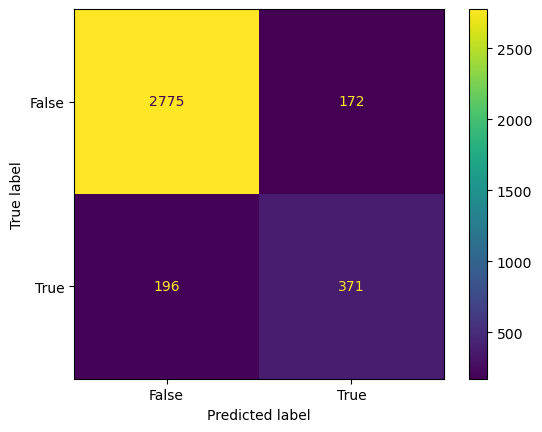

In [142]:
confusion_matrix = confusion_matrix(preds, y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Only a small uplift in performance. More feature engineering and pipline development could result in a better performing model, but here we will stop as this is for demonstration only.

In [72]:
joblib.dump(pipeline, 'model.pkl')

['model.pkl']

With the model saved we can move on to deployment.

## Step 4: Model Deployment

A python script called "deploy.py" was created seperately. It contains all of the preprocessing used here as well as model loading.

The below is how you can interact with the deployment.

In [129]:
q = X_holdout.sample(2).to_dict(orient='records')

In [132]:
response = requests.post('http://localhost:5000/predict', json=q)

In [133]:
prediction = json.loads(response.text)
print('Prediction:', prediction)

Prediction: {'prediction_0': {'label': 0, 'score': 0.9975011944770813}, 'prediction_1': {'label': 0, 'score': 0.9874539375305176}}
